In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from session import LossMeter, EvalModel
%matplotlib notebook

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

fulltrainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(1600))

fullvalset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(4480))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1], y)
        triplet = 0
        if (self.alpha > 0):
            for layer in x[:-1]:
                triplet += batch_hard_triplet_loss(layer.view(layer.size(0), -1), y, self.margin)

            triplet *= self.alpha
            
        return loss + triplet

In [7]:
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        return super().update(output[-1], label)

In [8]:
class EmbeddingSpaceValidator(TrainCallback):
    def __init__(self, val_data, num_embeddings, accuracy_meter_fn):
        self.val_data = val_data
        self.val_accuracy_meter = accuracy_meter_fn()
        self.train_accuracy_meter = accuracy_meter_fn()
        self.num_embeddings=num_embeddings
        
        self.train_accuracies = []
        self.batch_train_accuracies = []
        self.val_accuracies = []
        
        self.train_losses = []
        self.batch_train_losses = []
        self.train_bce_losses = []
        self.val_losses = []
        self.val_bce_losses = []
        
        self.batch_train_embedding_losses = [[] for x in range(self.num_embeddings)]
        self.val_embedding_losses = [[] for x in range(self.num_embeddings)]
        
        self.num_batches = 0
        self.num_epochs = 0
        
        self.epochs = []

    def run(self, session, lossMeter=None):
        self.val_accuracy_meter.reset()
            
        val_loss = LossMeter()
        val_bce_loss = LossMeter()
        embedding_losses = [LossMeter() for x in range(self.num_embeddings)]
        
        with EvalModel(session.model):
            for input, label, *_ in tqdm(self.val_data, desc="Validating", leave=True):
                label = Variable(util.to_gpu(label))
                output = session.forward(input)
                
                step_loss = session.criterion(output, label).data.cpu()
                
                val_loss.update(step_loss, input.shape[0])
                
                val_bce_loss.update(F.cross_entropy(output[-1], label).data.cpu(), input.shape[0])
                
                self.val_accuracy_meter.update(output, label)
                    
                for layer, embedding_loss in zip(output[:-1], embedding_losses):
                    embedding_loss.update(batch_all_triplet_loss(layer.view(layer.size(0), -1), label, 1).data.cpu())
        
        self.val_losses.append(val_loss.raw_avg.data.cpu().item())
        self.val_bce_losses.append(val_bce_loss.raw_avg.data.cpu().item())
        self.val_accuracies.append(self.val_accuracy_meter.accuracy())
        
        for meter, loss in zip(embedding_losses, self.val_embedding_losses):
            loss.append(meter.raw_avg.data.cpu().item())     
        
    def on_epoch_begin(self, session):
        self.train_accuracy_meter.reset()     
        self.train_bce_loss_meter = LossMeter()
        
    def on_epoch_end(self, session, lossMeter): 
        self.train_accuracies.append(self.train_accuracy_meter.accuracy())
        self.train_losses.append(lossMeter.debias.data.cpu().item())
        
        self.train_bce_losses.append(self.train_bce_loss_meter.raw_avg.data.cpu().item())
        
        self.run(session, lossMeter) 
        self.epochs.append(self.num_batches)
        self.num_epochs += 1
    
    def on_batch_end(self, session, lossMeter, output, label):
        label = Variable(util.to_gpu(label))
        batch_accuracy = self.train_accuracy_meter.update(output, label)
        self.batch_train_accuracies.append(batch_accuracy)
        self.batch_train_losses.append(lossMeter.loss.data.cpu().item())   
        self.train_bce_loss_meter.update(F.cross_entropy(output[-1], label).data.cpu(), label.shape[0])
             
        for layer, embedding_loss in zip(output[:-1], self.batch_train_embedding_losses):
            embedding_loss.append(batch_all_triplet_loss(layer.view(layer.size(0), -1), label, 1).data.cpu().item())
            
        self.num_batches += 1
            
    def plot(self):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_accuracies)
        #legend.append("Train accuracy per batch")
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_losses)
        #legend.append("Train loss per batch")
            
        ax1.plot(self.epochs, self.train_accuracies, '-o', label="Training accuracy per epoch")

        ax1.plot(self.epochs, self.val_accuracies, '-o', label="Validation accuracy per epoch")
        
        ax2.plot(self.epochs, self.train_losses, '-o', label="Training loss per epoch")
        
        ax2.plot(self.epochs, self.val_losses, '-o', label="Validation loss per epoch")
        
        ax3.plot(self.epochs, self.train_bce_losses, '-o', label="Training BCE loss per epoch")
        
        ax3.plot(self.epochs, self.val_bce_losses, '-o', label="Validation BCE loss per epoch")
        
        for embedding in self.batch_train_embedding_losses:
            ax4.plot(np.arange(self.num_batches), embedding, label="Train embedding triplet loss per batch")
        
        for embedding in self.val_embedding_losses:
            ax4.plot(self.epochs, embedding, '-o', label="Validation embedding triplet loss per epoch")
            
        for ax in (ax1, ax2, ax3, ax4):
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

In [9]:
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append(x)
        return list
    
model = SelectiveSequential(
    ['fc1', 'fc2', 'out'],
    {'conv32a': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     # 'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(),
     
     # 'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(7 * 7 * 128, 512),
     'actLinear': nn.ReLU(),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [10]:
criterion = TripletRegularizedCrossEntropyLoss(0, 1)

In [11]:
sess = Session(model, criterion, optim.Adam, 1e-3)

In [12]:
sess.set_lr(1e-4)

In [13]:
validator = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 60)

Validating: 100%|██████████| 70/70 [00:01<00:00, 43.55it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 35.40it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.83it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.49it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.73it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.69it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.34it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.17it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.73it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.31it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.44it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.25it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.27it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.45it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.41it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.63it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.79it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 35.79it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.61it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.88it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.00it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.63it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.60it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.78it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.28it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.48it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.46it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.84it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.29it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.24it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.70it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.89it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.00it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.82it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.73it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.58it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.36it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.78it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.08it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.07it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.57it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.52it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.12it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.85it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.54it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.36it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.72it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 36.12it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.66it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.83it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.27it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.72it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.20it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.31it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.20it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.73it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 37.35it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.43it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 35.26it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.96it/s]

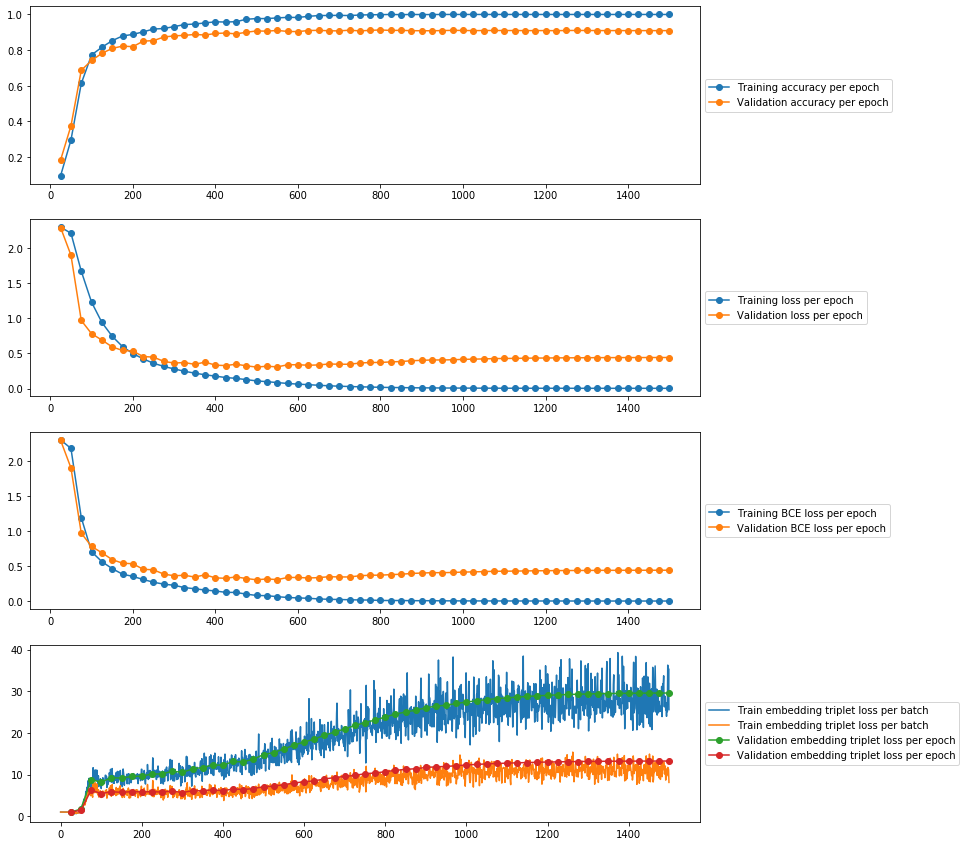

In [14]:
validator.plot()

In [16]:
model2 = SelectiveSequential(
    ['fc1', 'fc2', 'out'],
    {'conv32a': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(),
     # 'drop1': nn.Dropout(.1),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(),
     # 'drop1': nn.Dropout(.1),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(),
     # 'drop1': nn.Dropout(.12),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(),
     # 'drop1': nn.Dropout(.12),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(),
     # 'drop1': nn.Dropout(.12),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     # 'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(),
     # 'drop1': nn.Dropout(.12),
     
     # 'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(7 * 7 * 128, 512),
     
     'actLin': nn.ReLU(),
     
     # 'drop9': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     # 'drop10': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [17]:
criterion = TripletRegularizedCrossEntropyLoss(.25, 1)

In [18]:
sess = Session(model2, criterion, optim.Adam, 1e-4)

In [19]:
validator2 = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler2 = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-6)
schedule2 = TrainingSchedule(trainloader, [lr_scheduler2, validator2])
sess.train(schedule2, 60)

Validating: 100%|██████████| 70/70 [00:01<00:00, 38.67it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.96it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.13it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 41.04it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 40.40it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.56it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 39.61it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 30.69it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.47it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.58it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.58it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 29.28it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.69it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.14it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.54it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.44it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.89it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.69it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.58it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.45it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.35it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.60it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 30.97it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 30.83it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.22it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.91it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.50it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.17it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.43it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.16it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.84it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.22it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.90it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.66it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.45it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.41it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.12it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.96it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.96it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.47it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.32it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.55it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.36it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.32it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.48it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.03it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 30.37it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.18it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.12it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.69it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.13it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.59it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 31.72it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 32.68it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 34.34it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 33.18it/s]


Validating: 100%|██████████| 70/70 [00:02<00:00, 31.47it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.16it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.62it/s]


Validating: 100%|██████████| 70/70 [00:01<00:00, 38.52it/s]

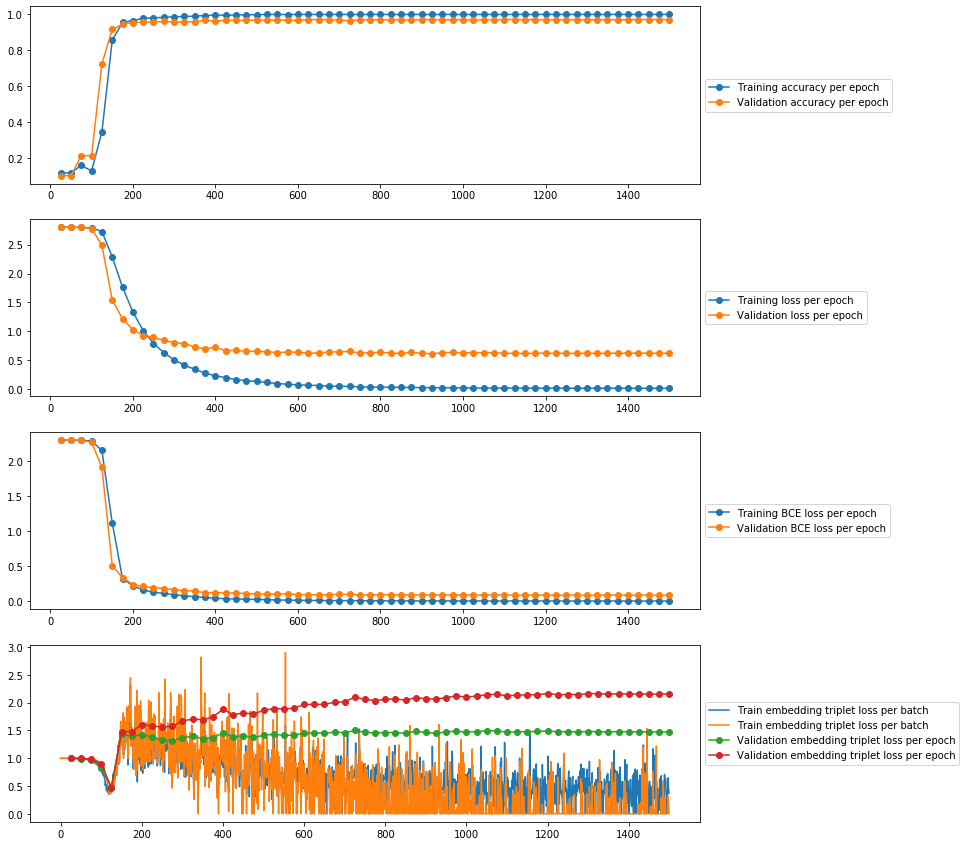

In [20]:
validator2.plot()

In [21]:
np.max(validator2.val_accuracies), "Best accuracy with reg"

(0.9716517857142857, 'Best accuracy with reg')

In [22]:
np.max(validator.val_accuracies), "Best accuracy without reg"

(0.9129464285714286, 'Best accuracy without reg')